In [9]:
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, LpMaximize, LpStatus, LpInteger
import sympy as sym
import random

## Задача 1

Функции для решений

In [12]:
def get_plan_by_min_tariff_method(M, A, B):


    a_total = A.sum()
    b_total = B.sum()

    sorted_indexes = list(sorted(((i, j) for j in range(M.shape[1]) for i in range(M.shape[0])), key=lambda x: M[x[0], x[1]]))

    X_star = np.zeros(M.shape)
    A = A.copy()
    B = B.copy()

    for i, j in sorted_indexes:
        if B[j] > 0 and A[i] > 0:
            X_star[i, j] = min(A[i], B[j])
            A[i] -= X_star[i, j]
            B[j] -= X_star[i, j]

            a_total -= X_star[i, j]
            b_total -= X_star[i, j]
        if a_total == 0 or b_total == 0:
            break

    return X_star

In [13]:
def solve_transport_lp_method(C, A, B):
    i_s = ord('a')
    n, m = C.shape
    # Переменные
    X = np.array(list(LpVariable(f'{chr(i)}', lowBound=0, cat=LpInteger) for i in range(i_s, i_s + n * m)))\
        .reshape((n, m))

    # Целевая функция
    F = (C * X).sum()

    le = np.vectorize(lambda x, y: x <= y)
    eq = np.vectorize(lambda x, y: x == y)

    # Ограничения запасов
    C1 = le(X.sum(axis=1), A)
    # Ограничения потребностей
    C2 = eq(X.sum(axis=0), B)

    model = LpProblem("Distribution_Problem", LpMinimize)
    model += F
    for i in [C1, C2]:
        for j in i:
            model += j

    model.solve()


    X_star = np.vectorize(lambda x: x.value())(np.array(model.variables()))

    print('Оптимальный план перевозки:')
    print(X_star.reshape((n, m)))

    print(f'Оптимальная стоимость перевозки: {model.objective.value()}')

In [18]:
inf = 1000

M = np.array([
    [5, 7, 12, 3],
    [7, 8, 9, 10],
    [7, 11, 6, 6]
])

A = np.array([50, 90, 110])
B = np.array([110, 20, 20, 100])

In [19]:
X_star = get_plan_by_min_tariff_method(M, A, B)
X_star

array([[ 0.,  0.,  0., 50.],
       [90.,  0.,  0.,  0.],
       [20., 20., 20., 50.]])

In [21]:
(X_star * M).sum()

1560.0

Проверим оптимальность транспортной задачи

In [20]:
solve_transport_lp_method(M, A, B)

Оптимальный план перевозки:
[[ 0.  0.  0. 50.]
 [70. 20.  0.  0.]
 [40.  0. 20. 50.]]
Оптимальная стоимость перевозки: 1500.0


**Вывод**: начальный опорный план неоптимальный. Следует продолжить итерации поиска.

## Задача 2

Функция упрощение матрицы (исключение доминируемых/доминирующих стратегий)

In [3]:
ge = np.vectorize(lambda x, y: x >= y)
le = np.vectorize(lambda x, y: x <= y)

def reduce_game_matrix(A, f_u):
    A_final = []

    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if i == j:
                continue

            if f_u(A[i], A[j]).all():
                break
        else:
            A_final.append(A[i])

    A_final = np.array(A_final)
    return np.unique(A_final, axis=0)

In [22]:
# Решение симплекс-методом
def get_mixed_strategy(M, F_type, C_type_f):
    model = LpProblem("Game", F_type)
    W = []

    for i in range(M.shape[1]):
        w = LpVariable(f'w{i + 1}', lowBound=0)
        W.append(w)



    W = np.array(W)

    F = (W).sum()
    C = C_type_f((M * W).sum(axis=1), 1)

    model += F
    for constraint in C:
        model += constraint

    model.solve()

    opt = np.array(list(map(lambda x: x.value(), model.variables())))

    v = 1 / opt.sum()
    opt = opt / opt.sum()
    return opt, v


def solve_matrix_game(strategies_A, strategies_B, M):
    worst_response_scenarios_A = M.min(axis=1)
    worst_response_scenarios_B = M.max(axis=0)
    opt_strategy_A = worst_response_scenarios_A.argmax() # alpha - нижняя цена игры (максимин) - Это максимальный выигрыш игрока A
    opt_strategy_B = worst_response_scenarios_B.argmin() # beta - верхняя цена игры (минимакс) - Это максимальный проигрыш игрока В


    opt, v = get_mixed_strategy(M.T, LpMinimize, ge)
    opt_b, v_b = get_mixed_strategy(M, LpMaximize, le)

    res = f'a) Оптимальная чистая стратегия для игрока А: №{opt_strategy_A + 1} - {strategies_A[opt_strategy_A]}\n' \
      f'б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  {worst_response_scenarios_A[opt_strategy_A]}\n' \
      f'в) Оптимальная чистая стратегия для игрока Б: №{opt_strategy_B + 1} - {strategies_B[opt_strategy_B]}\n' \
      f'г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: {worst_response_scenarios_B[opt_strategy_B]}\n' \
      f'д) Таблица смешанных стратегий для игрока А: {opt}\n' \
      f'е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: {v}\n' \
      f'ж) Таблица смешанных стратегий для игрока Б: {opt_b}\n' \
      f'з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: {v_b}'

    print(res)

    return {'A': (opt, v), 'B': (opt_b, v_b)}



def get_func_by_points(p1, p2):
    return lambda x: (x - p1[0]) * (p2[1] - p1[1]) / (p2[0] - p1[0]) + p1[1]


def solve_matrix_game_graphic_method(A, inverse=False):

    A_origin = A

    if inverse:
        x_name = 'B'
        y_name = 'A'
        ueq = ge
        A = A.T
        obj = 'B'
        strategy_s = 'q'
    else:
        x_name = 'A'
        y_name = 'B'
        ueq = le
        obj = 'A'
        strategy_s = 'p'

    offset = 0.05

    x_sym = sym.Symbol('x')
    y_sym = sym.Symbol('y')
    plot_main = sym.plot(show=False, xlim=(0 - offset, 1 + offset), ylim=(0 - offset, A.max() + offset))


    B = A.T
    B_points = []
    for i in range(B.shape[0]):
        p = []
        for j in range(B.shape[1]):
            p.append([j, B[i, j]])
        B_points.append(p)


    def print_straight(p, v, v_name, color):
        f = get_func_by_points(*v)
        p.append(
            sym.plot(f(x_sym),
                     show=False,
                     line_color=color)[0])
        return f

    b_funcs = []


    for i in range(len(B_points)):
        b_f = print_straight(plot_main, np.array(B_points[i]), f'{y_name}{i + 1}', 'red')
        b_funcs.append(b_f)

    plot_main.append(
        sym.plot_implicit(
            sym.And(*map(lambda f: ueq(y_sym, f(x_sym)), b_funcs)),
            ('x',0, 1),
            ('y',0, 20),
            show=False,
            line_color="#2BE68F",
        )[0])

    plot_main.append(sym.plot(0, show=False, line_color='blue')[0])

    plot_main.markers = []
    plot_main.annotations = []
    for i in range(len(B_points)):
        for x, y in B_points[i]:
            plot_main.markers.append({'args': [x, y, 'go'], 'color':'red'})

            plot_main.annotations.append(
                 {'xy': (x + offset, y), 'text': f'{y_name}{i+1}', 'ha': 'left', 'va': 'top', 'color': 'red'}
            )

    plot_main.annotations.extend([
        {'xy': (0 + offset, 0 + offset), 'text': f'{x_name}1', 'ha': 'left', 'va': 'top', 'color': 'blue'},
        {'xy': (1 - offset, 0 + offset), 'text': f'{x_name}2', 'ha': 'left', 'va': 'top', 'color': 'blue'}
    ]
    )

    plot_main.markers.extend(
        [{'args': [0, 0, 'go'], 'color':'blue'},
         {'args': [1, 0, 'go'], 'color':'blue'}]
    )


    opt, v = solve_matrix_game(['A1', 'A2'], ['B1', 'B2', 'B3'], A_origin)[obj]
    print(v)


    plot_line = sym.plot_implicit(sym.And(sym.Eq(x_sym, opt[1])), ('x', 0, 10), ('y', 0, v), show=False, line_color='gold')[0]

    plot_main.markers.append({'args': [opt[1], v, 'go'], 'color':'gold'})
    plot_main.annotations.append({'xy': (opt[1] + offset, v + offset), 'text': f'M*{opt[1], v}', 'ha': 'left', 'va': 'top', 'color': 'gold'})

    plot_main.markers.append({'args': [opt[1], 0, 'go'], 'color':'gold'})
    plot_main.annotations.append({'xy': (opt[1] + offset, 0 + offset), 'text': f'S_A* = {opt[1]} = {strategy_s}2', 'ha': 'left', 'va': 'top', 'color': 'gold'})

    plot_main.append(plot_line)
    plot_main.show()

In [28]:
A = np.array([
    [1, 6, 1, 4],
    [5, 8, 4, 5],
    [3, 7, 8, 2],
    [5, 6, 2, 3]
])

In [29]:
A_reduced = reduce_game_matrix(reduce_game_matrix(A, le).T, ge).T

In [30]:
A_reduced

array([[2, 8],
       [5, 4]])

a) Оптимальная чистая стратегия для игрока А: №2 - A2
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  4
в) Оптимальная чистая стратегия для игрока Б: №1 - B1
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 5
д) Таблица смешанных стратегий для игрока А: [0.14285714 0.85714286]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 4.571428571428571
ж) Таблица смешанных стратегий для игрока Б: [0.57142857 0.42857143]
з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 4.571428571428571
4.571428571428571


C:\Users\sergi\PycharmProjects\PythonEnv\venv\lib\site-packages\sympy\plotting\plot.py:1500: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax.plot(*args, **m)


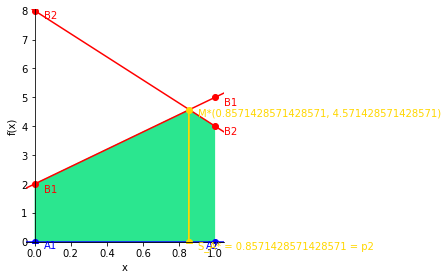

In [31]:
solve_matrix_game_graphic_method(A_reduced)

Проверка на исходном

In [32]:
solve_matrix_game(['A1', 'A2', 'A3', 'A4'], ['B1', 'B2', 'B3', 'B4'], A)

a) Оптимальная чистая стратегия для игрока А: №2 - A2
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  4
в) Оптимальная чистая стратегия для игрока Б: №1 - B1
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 5
д) Таблица смешанных стратегий для игрока А: [0.         0.85714286 0.14285714 0.        ]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 4.571428571428571
ж) Таблица смешанных стратегий для игрока Б: [0.         0.         0.42857143 0.57142857]
з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 4.571428571428571


{'A': (array([0.        , 0.85714286, 0.14285714, 0.        ]),
  4.571428571428571),
 'B': (array([0.        , 0.        , 0.42857143, 0.57142857]),
  4.571428571428571)}

## Задача 3

In [34]:
def solve_dynamic_continuous_problem(s_e, f1, f2, fi1, fi2, n):
    x = LpVariable('x', lowBound=0)
    y = LpVariable('y', lowBound=0)

    # F = f1(x) + f2(y) + f1(fi1(x)) + f2(fi2(y)) + f1(fi1(fi1(x))) + f2(fi2(fi2(y))) # можно написать рекурсией

    def F(acc, w1, w2, n):
        if n == 0:
            return acc
        return F (acc + f1(w1) + f2(w2), fi1(w1), fi2(w2), n-1)


    print(F(0, x, y, n))
    model = LpProblem("Game", LpMaximize)
    model += F(0, x, y, n)

    model += x + y == s_e

    model.solve()

    X = list(map(lambda x: x.value(), model.variables()))
    F_star = model.objective.value()

    return X, F_star

In [35]:
S0 = 3000
f1 = lambda x: 0.7*x # прибыль в конце года 1 предприятия
fi1 = lambda x: 0.2*x  # возврат средств в конце года 1 предприятия

f2 = lambda y: 0.6*y # прибыль в конце года 2 предприятия
fi2 = lambda y: 0.4*y # возврат средств в конце года 2 предприятия
n = 3

In [36]:
solve_dynamic_continuous_problem(S0, f1, f2, fi1, fi2, n)

0.868*x + 0.9359999999999999*y


([0.0, 3000.0], 2808.0)

In [37]:
class LP:
    def __init__(self, D, F, a=1, b=1, c=1):
        self.a = a
        self.b = b
        self.c = c
        self.s_F = F

        if not isinstance(F, sym.Add):
            self.F = sym.parse_expr(F).subs(dict(a=a, b=b, c=c))
        else:
            self.F = F


        if not isinstance(D, np.ndarray):
            self.D = list(map(lambda x: sym.parse_expr(x).subs(dict(a=a, b=b, c=c)), D))
        else:
            self.D = D

        self.colors_f = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
        self.colors = self.colors_f(len(self.D))


        self.x_coord = (-20, 20)
        self.y_coord = (-20, 20)


        self.model = self._create_model()


    def _create_model(self):
        model = LpProblem(name="resource-allocation", sense = LpMaximize)
        x1 = LpVariable(name="x_1")
        x2 = LpVariable(name="x_2")
        model += sym.lambdify(['x_1', 'x_2'], self.F)(x1, x2)

        for d in self.D:
            f = lambda x_1, x_2: eval(str(d))
            model += f(x1, x2)

        model.solve()

        return model



    def __repr__(self):
        status = self.model.status
        x1_total = self.model.variables()[0].value()
        x2_total = self.model.variables()[1].value()
        F = self.model.objective.value()

        self.show_graphic()

        return f'Статус решения: {status}, {LpStatus[status]}\n' \
               f'Оптимальное значение целевой функции: {int(F)}\n' \
               f'Оптимальный план: (x1 = {int(x1_total)}, x2 = {int(x2_total)})'




    def show_graphic(self):
        d_names = list(map(lambda i: f"C{i + 1}", range(len(self.D))))

        x1_total = self.model.variables()[0].value()
        x2_total = self.model.variables()[1].value()

        p = sym.plot_implicit(sym.And(*self.D),
                              ('x_1', *self.x_coord),
                              ('x_2', *self.y_coord),
                              line_color="#2BE68F",
                              show=False,
                              markers=[{'args': [x1_total, x2_total, 'go'], 'color':'#0AFFF4'}]
                              )

        for i in range(len(self.colors)):
            p.append(sym.plot_implicit(
                sym.Eq(*self.D[i].args),
                ('x_1', *self.x_coord),
                ('x_2', *self.y_coord),
                line_color=self.colors[i],
                adaptive=False,
                show=False)[0])




        print(sym.Eq(self.F, self.model.objective.value()))

        p.append(sym.plot_implicit(sym.Eq(self.F, self.model.objective.value()),
                                   ('x_1', *self.x_coord),
                                   ('x_2', *self.y_coord),
                                   line_color='black', adaptive=False, show=False)[0])

        p.append(sym.plot_implicit(sym.Eq(self.F, 2),
                                   ('x_1', *self.x_coord),
                                   ('x_2', *self.y_coord),
                                   line_color='#808080', adaptive=False, show=False)[0])


        p.annotations = []
        o = 20



        for i in range(len(d_names)):
            p.annotations.append(
                {'xy': (15, o), 'text': d_names[i], 'ha': 'left', 'va': 'top', 'color': self.colors[i]}
            )
            o -= 2

        p.annotations.append(
            {'xy': (15, o), 'text': f'F={self.model.objective.value()}', 'ha': 'left', 'va': 'top', 'color': 'black'}
        )

        p.annotations.append(
            {'xy': (15, o - 2), 'text': 'F=2', 'ha': 'left', 'va': 'top', 'color': '#808080'}
        )

        p.annotations.append(
            {'xy': (x1_total + 2, x2_total), 'text': f'M*({x1_total}, {x2_total})', 'ha': 'left', 'va': 'top', 'color': '#0AFFF4'}
        )


        f_opt = 'x_1 +' + str(-1/self.a) + '*x_2'
        opt_l = sym.plot_implicit(sym.Eq(sym.parse_expr(f_opt), x1_total + -1/self.a * x2_total),
                           ('x_1', *self.x_coord),
                           ('x_2', *self.y_coord),
                           line_color='#0AFFF4', adaptive=False, show=False)

        p.annotations.append(
                {'xy': (15, o - 4), 'text': 'solution arrow', 'ha': 'left', 'va': 'top', 'color': '#0AFFF4'})

        p.append(opt_l[0])

        p.show()

In [86]:
model = LpProblem('dynamic', sense=LpMaximize)

x1 = LpVariable('x1', lowBound=0)
x2 = LpVariable('x2', lowBound=0)
x3 = LpVariable('x3', lowBound=0)

y1 = LpVariable('y1', lowBound=0)
y2 = LpVariable('y2', lowBound=0)
y3 = LpVariable('y3', lowBound=0)



f1 = 0.7 * x1 + 0.6 * y1
f2 = 0.7 * x2 + 0.6 * y2
f3 = 0.7 * x3 + 0.6 * y3

F = f1 + f2 + f3

model += x1 + y1 == 3000
model += 0.2 * x1 + 0.4 * y1 == x2 + y2
model += 0.2 * x2 + 0.4 * y2 == x3 + y3

model

dynamic:
MAXIMIZE
None
SUBJECT TO
_C1: x1 + y1 = 3000

_C2: 0.2 x1 - x2 + 0.4 y1 - y2 = 0

_C3: 0.2 x2 - x3 + 0.4 y2 - y3 = 0

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
y1 Continuous
y2 Continuous
y3 Continuous

In [87]:
model.solve()

1

In [89]:
model.variables()

[__dummy, x1, x2, x3, y1, y2, y3]

In [88]:
list(map(lambda x: x.value(), model.variables()))

[None, 3000.0, 600.0, 120.0, 0.0, 0.0, 0.0]

In [91]:
0.7 * 3000 + 0.7 * 600 + 0.7 * 120

2604.0

In [95]:
S0 = 3000
f1 = lambda x: 0.7*x # прибыль в конце года 1 предприятия
fi1 = lambda x: 0.2*x  # возврат средств в конце года 1 предприятия

f2 = lambda y: 0.6*y # прибыль в конце года 2 предприятия
fi2 = lambda y: 0.4*y # возврат средств в конце года 2 предприятия
n = 3

In [96]:
solve_dynamic_continuous_problem(S0, f1, f2, fi1, fi2, n)

0.868*x + 0.9359999999999999*y


([0.0, 3000.0], 2808.0)